In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.1929 - loss: 2.4736

100/100 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.1943 - loss: 2.4692 - val_accuracy: 0.5424 - val_loss: 1.4575
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.6042 - loss: 1.3043

100/100 ━━━━━━━━━━━━━━━━━━━━ 68s 680ms/step - accuracy: 0.6046 - loss: 1.3037 - val_accuracy: 0.6809 - val_loss: 1.1507
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7058 - loss: 1.0842

100/100 ━━━━━━━━━━━━━━━━━━━━ 74s 743ms/step - accuracy: 0.7058 - loss: 1.0841 - val_accuracy: 0.7161 - val_loss: 1.0350
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.7196 - loss: 1.0175

100/100 ━━━━━━━━━━━━━━━━━━━━ 77s 769ms/step - accuracy: 0.7197 - loss: 1.0172 - val_accuracy: 0.7284 - val_loss: 0.9925
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.7529 - loss: 0.8988

100/100 ━━━━━━━━━━━━━━━━━━━━ 49s 496ms/step - accuracy: 0.7529 - loss: 0.8987 - val_accuracy: 0.7288 - val_loss: 0.9678
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.7451 - loss: 0.9220

100/100 ━━━━━━━━━━━━━━━━━━━━ 56s 562ms/step - accuracy: 0.7451 - loss: 0.9218 - val_accuracy: 0.7398 - val_loss: 0.9351
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.7690 - loss: 0.8420

100/100 ━━━━━━━━━━━━━━━━━━━━ 85s 850ms/step - accuracy: 0.7689 - loss: 0.8423 - val_accuracy: 0.7504 - val_loss: 0.8976
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 399ms/step - accuracy: 0.7671 - loss: 0.8373 - val_accuracy: 0.7428 - val_loss: 0.9310
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.7791 - loss: 0.7913

100/100 ━━━━━━━━━━━━━━━━━━━━ 61s 609ms/step - accuracy: 0.7791 - loss: 0.7916 - val_accuracy: 0.7598 - val_loss: 0.8743
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.7729 - loss: 0.8029

100/100 ━━━━━━━━━━━━━━━━━━━━ 74s 743ms/step - accuracy: 0.7730 - loss: 0.8026 - val_accuracy: 0.7675 - val_loss: 0.8439
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


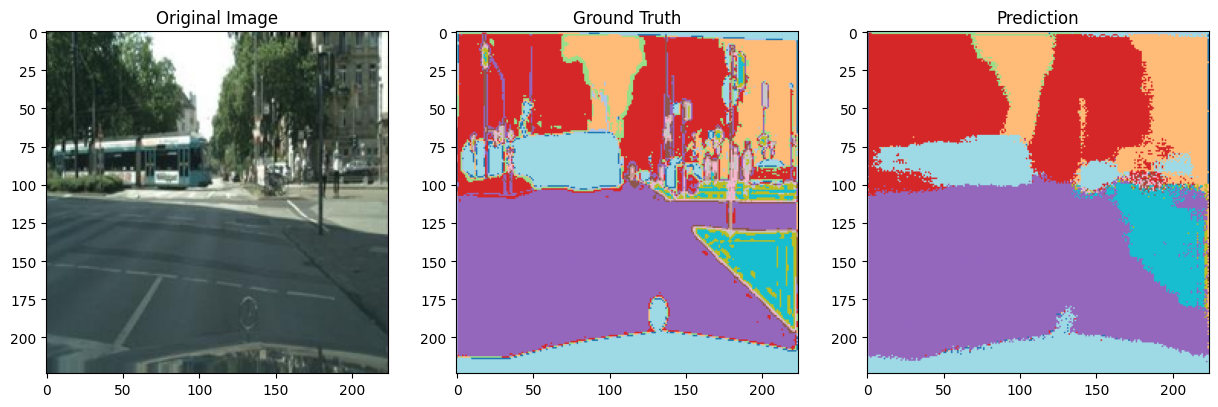

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Activation, Add
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Parameters
IMG_SIZE = 224
CLASSES = 13
BATCH_SIZE = 8

# Data generator
def data_generator(folder_path, batch_size=8):
    files = os.listdir(folder_path)
    while True:
        for i in range(0, len(files), batch_size):
            batch_files = files[i:i+batch_size]
            images, masks = [], []

            for file in batch_files:
                # Load and split image (left: image, right: mask)
                img = Image.open(os.path.join(folder_path, file)).resize((IMG_SIZE*2, IMG_SIZE))
                img_array = np.array(img)

                # Split into image and mask
                image = img_array[:, :IMG_SIZE] / 255.0
                mask = img_array[:, IMG_SIZE:]

                # Convert mask to class indices
                bins = np.array([20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240])
                class_mask = np.digitize(mask[:, :, 0], bins) - 1

                # One-hot encode mask
                one_hot_mask = np.eye(CLASSES)[class_mask]

                images.append(image)
                masks.append(one_hot_mask)

            yield np.array(images), np.array(masks)

# FCN-8 model
def create_fcn_model():
    # Base model
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

    # Get feature maps from different blocks
    block3_pool = base_model.get_layer('block3_pool').output
    block4_pool = base_model.get_layer('block4_pool').output
    block5_pool = base_model.get_layer('block5_pool').output

    # FCN layers
    x = Conv2D(4096, (7, 7), activation='relu', padding='same')(block5_pool)
    x = Conv2D(4096, (1, 1), activation='relu', padding='same')(x)

    # Skip connections (FCN-8)
    x = Conv2DTranspose(CLASSES, (4, 4), strides=2, padding='same')(x)
    skip1 = Conv2D(CLASSES, (1, 1), padding='same')(block4_pool)
    x = Add()([x, skip1])

    x = Conv2DTranspose(CLASSES, (4, 4), strides=2, padding='same')(x)
    skip2 = Conv2D(CLASSES, (1, 1), padding='same')(block3_pool)
    x = Add()([x, skip2])

    # Final upsampling
    x = Conv2DTranspose(CLASSES, (16, 16), strides=8, padding='same')(x)
    outputs = Activation('softmax')(x)

    return Model(inputs=base_model.input, outputs=outputs)

# Create model
model = create_fcn_model()
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Data generators
train_gen = data_generator('/content/drive/MyDrive/7th Sem/DL/cityscapes_data/train', BATCH_SIZE)
val_gen = data_generator('/content/drive/MyDrive/7th Sem/DL/cityscapes_data/val', BATCH_SIZE)

# Train model
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
history = model.fit(train_gen, steps_per_epoch=100, epochs=10,
                    validation_data=val_gen, validation_steps=50, callbacks=[checkpoint])

# Visualize results
def visualize_prediction(model, data_gen):
    images, masks = next(data_gen)
    pred = model.predict(images[:1])

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(images[0])
    axes[0].set_title('Original Image')

    axes[1].imshow(np.argmax(masks[0], axis=-1), cmap='tab20')
    axes[1].set_title('Ground Truth')

    axes[2].imshow(np.argmax(pred[0], axis=-1), cmap='tab20')
    axes[2].set_title('Prediction')

    plt.show()

visualize_prediction(model, val_gen)

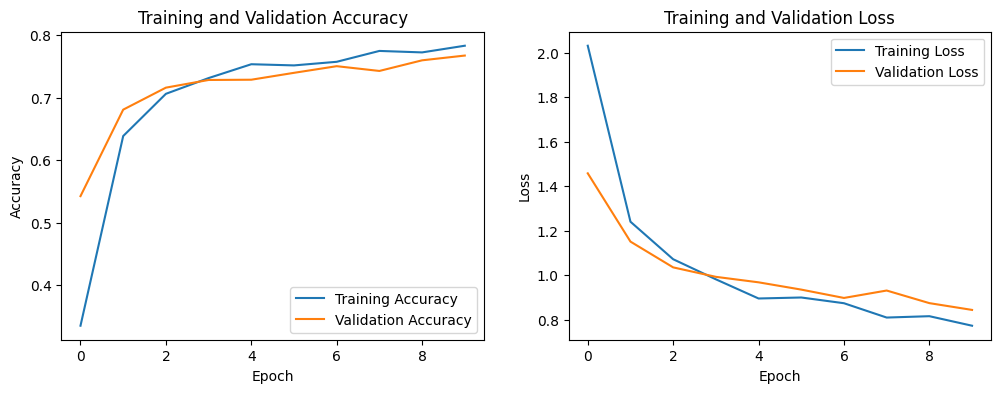

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()